# Track Woody Cover Fraction Through Time

You will need:
- The WCF model
- A polygon for the area of interest

The steps are:
1. Import necessary modules
2. Import data
    - Import your polygon
    - Load satellite data occurring at the polygon
3. Calculate WCF
    - Import WCF model
    - Calculate WCF
4. Calculate statistics over polygon
    - Save as csv

### 1. Import modules

In [76]:
%matplotlib inline

import sys
import datacube
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
import rasterio

from scipy import stats
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS

from datacube.utils import geometry # needed to turn shapefile into queriable geometry
from rasterio import features # needed to convert polygon into raster for masking

sys.path.append('dev/dea-notebooks/Gabrielle_dev/LCCS_wet_veg/Scripts')
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices
from dea_classificationtools import predict_xr
from dea_classificationtools import sklearn_unflatten
from dea_classificationtools import sklearn_flatten
import dea_plotting
from dea_plotting import display_map
from dea_plotting import rgb

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [77]:
dc = datacube.Datacube()

### 2. Import data

In [91]:
geotiff_path = 'dev/dea-notebooks/Gabrielle_dev/LCCS_wet_veg/rice_binary_sample.tif'

# Open into an xarray.DataArray
geotiff_da = xr.open_rasterio(geotiff_path)

# Covert our xarray.DataArray into a xarray.Dataset
geotiff_ds = geotiff_da.to_dataset('band')

# Rename the variable to a more useful name
geotiff_ds = geotiff_ds.rename({1: 'rice'})

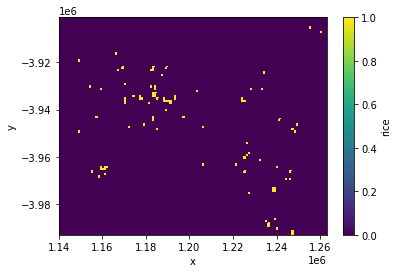

In [92]:
geotiff_ds.rice.plot()

In [93]:
min_x = geotiff_ds.coords['x'].values.min()
max_x = geotiff_ds.coords['x'].values.max()
min_y = geotiff_ds.coords['y'].values.min()
max_y = geotiff_ds.coords['y'].values.max()

#### Satellite data

Define parameters

In [94]:
# Define the aoi
# lat = (-27.8, -28.0)
# lon = (145.3, 145.7)

lon = (min_x, max_x)
lat = (min_y, max_y)

In [95]:
# Check location
display_map(x=lon, y=lat, crs = 'EPSG:3577')

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: h

Create the query

In [123]:
# Filter date
time = ('2014-06-01', '2015-06-30')

# Choose products to load
# Here, the ARD landsat data is chosen ga_ls8c_ard_3
#products = ["ls8_nbart_geomedian_annual","ls5_nbart_geomedian_annual"]
products = ["ga_ls8c_ard_3"]

# Specify the parameters to pass to the load query
query = {
    "x": lon,
    "y": lat,
#     "geopolygon":geom,
    "time": time,
    # Make sure the order is correct for the model: blue, green, red, nir, swir1 and swir2 
#      "measurements": ["nbart_blue", "nbart_green", "nbart_red", "nbart_nir", "nbart_swir_1", "nbart_swir_2"],
    "measurements": ["blue", "green", "red", "nir", "swir1", "swir2"],
    "output_crs": 'EPSG:3577',
    "crs":'EPSG:3577',
    "resolution": (-25, 25),
    "group_by": 'solar_day'
}

Import the data

In [124]:
ds = dc.load(product=products, **query)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 66, x: 4880, y: 3640)
Coordinates:
  * time         (time) datetime64[ns] 2014-06-07T00:02:19.145274 ... 2015-06-26T00:01:58.947291
  * y            (y) float64 -3.902e+06 -3.902e+06 ... -3.992e+06 -3.992e+06
  * x            (x) float64 1.141e+06 1.141e+06 ... 1.262e+06 1.262e+06
    spatial_ref  int32 3577
Data variables:
    blue         (time, y, x) int16 -999 -999 -999 -999 -999 ... 334 332 332 343
    green        (time, y, x) int16 -999 -999 -999 -999 -999 ... 523 542 542 559
    red          (time, y, x) int16 -999 -999 -999 -999 -999 ... 611 638 638 648
    nir          (time, y, x) int16 -999 -999 -999 -999 ... 1459 1489 1489 1607
    swir1        (time, y, x) int16 -999 -999 -999 -999 ... 1689 1712 1712 1769
    swir2        (time, y, x) int16 -999 -999 -999 -999 ... 1257 1286 1286 1309
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


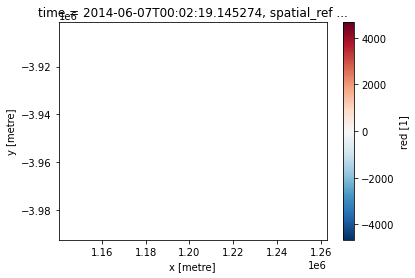

In [125]:
ds.isel(time=0).red.plot()

### 3. Calculate indices

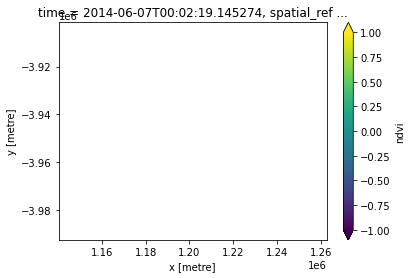

In [126]:
ds['ndvi'] = (ds['nir']-ds['red'])/(ds['nir']+ds['red'])    
ds.isel(time=0).ndvi.plot(vmin=-1,vmax=1)

### 4. Calculate statistics

In [127]:
ds

<xarray.Dataset>
Dimensions:      (time: 66, x: 4880, y: 3640)
Coordinates:
  * time         (time) datetime64[ns] 2014-06-07T00:02:19.145274 ... 2015-06-26T00:01:58.947291
  * y            (y) float64 -3.902e+06 -3.902e+06 ... -3.992e+06 -3.992e+06
  * x            (x) float64 1.141e+06 1.141e+06 ... 1.262e+06 1.262e+06
    spatial_ref  int32 3577
Data variables:
    blue         (time, y, x) int16 -999 -999 -999 -999 -999 ... 334 332 332 343
    green        (time, y, x) int16 -999 -999 -999 -999 -999 ... 523 542 542 559
    red          (time, y, x) int16 -999 -999 -999 -999 -999 ... 611 638 638 648
    nir          (time, y, x) int16 -999 -999 -999 -999 ... 1459 1489 1489 1607
    swir1        (time, y, x) int16 -999 -999 -999 -999 ... 1689 1712 1712 1769
    swir2        (time, y, x) int16 -999 -999 -999 -999 ... 1257 1286 1286 1309
    ndvi         (time, y, x) float64 -0.0 -0.0 -0.0 ... 0.4001 0.4001 0.4253
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [128]:
geotiff_ds

<xarray.Dataset>
Dimensions:  (x: 123, y: 92)
Coordinates:
  * y        (y) float64 -3.902e+06 -3.902e+06 ... -3.992e+06 -3.992e+06
  * x        (x) float64 1.140e+06 1.142e+06 1.142e+06 ... 1.262e+06 1.262e+06
Data variables:
    rice     (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    transform:      (1000.0, 0.0, 1140000.0, 0.0, -1000.0, -3901000.0)
    crs:            +proj=aea +lat_0=0 +lon_0=132 +lat_1=-18 +lat_2=-36 +x_0=...
    res:            (1000.0, 1000.0)
    is_tiled:       1
    nodatavals:     (255.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    DataType:       Generic

In [129]:
ds_masked = ds.where(mask)
ds_masked

<xarray.Dataset>
Dimensions:      (time: 66, x: 0, y: 0)
Coordinates:
  * x            (x) float64 
  * y            (y) float64 
  * time         (time) datetime64[ns] 2014-06-07T00:02:19.145274 ... 2015-06-26T00:01:58.947291
    spatial_ref  int32 3577
Data variables:
    *empty*
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [109]:
# Mask area outside of polygon - remember we loaded data for the complete bounding box
mask = geotiff_ds

# Apply raster mask to dataset. This will automatically apply the mask to 
# all timesteps and bands in the dataset.
ds_masked = ds.where(mask)

# Plot a single timestep in RGB to verify that data outside the polygon has been masked out
ds_masked.isel(time=0).ndvi.plot()

AttributeError: 'Dataset' object has no attribute 'ndvi'

In [ ]:
# Calculate mean WCF
mean = wcf_masked.mean(dim=['x', 'y'])

# Add to a single dataframe ready to be written out as a CSV with time as an index
mean_df = pd.DataFrame(data={'wcf_mean': mean}, index=wcf.time.values)

# Write to file
mean_df.to_csv(f'wcf_mean_{time[0]}-{time[1]}.csv', index_label='time')

# Preview data
mean_df.head()

In [ ]:
# Plot the trace through time
mean_df.plot()